In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop  # Change optimizer to RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow as tf  # Import TensorFlow for custom learning rate scheduler


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Define a function to load and preprocess images
def load_and_preprocess_images1(folder_path, max_images=5000):
    images = []
    labels = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    for image_file in image_files:
        if max_images <= 0:
            break

        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in color
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(0)  # for biodegradable
            max_images -= 1
    return images, labels

In [3]:
# Define a function to load and preprocess images
def load_and_preprocess_images2(folder_path, max_images=5000):
    images = []
    labels = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    for image_file in image_files:
        if max_images <= 0:
            break

        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in color
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(1)  # non biodegradab;le
            max_images -= 1
    return images, labels

In [4]:
# Define a function to load and preprocess images
def load_and_preprocess_images3(folder_path, max_images=5000):
    images = []
    labels = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    for image_file in image_files:
        if max_images <= 0:
            break

        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in color
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(2)  # recyclable
            max_images -= 1
    return images, labels

In [5]:

# biodegradable -> 0
# non bio -> 1
# recyclable -> 2
            

In [6]:
# Load and preprocess the images for each category
biodegradable_images, labels_biodegradable = load_and_preprocess_images1('/kaggle/input/waste-classifier/O')
non_biodegradable_images, labels_non_biodegradable = load_and_preprocess_images2('/kaggle/input/waste-classifier/NB')
recyclable_images, labels_recyclable = load_and_preprocess_images3('/kaggle/input/waste-classifier/R')


In [7]:
images = []
labels = []

biodegradable_count = len(biodegradable_images)
non_biodegradable_count = len(non_biodegradable_images)
recyclable_count = len(recyclable_images)

max_count = max(biodegradable_count, non_biodegradable_count, recyclable_count)

for i in range(max_count):
    if i < biodegradable_count:
        images.append(biodegradable_images[i])
        labels.append(labels_biodegradable[i])
    if i < non_biodegradable_count:
        images.append(non_biodegradable_images[i])
        labels.append(labels_non_biodegradable[i])
    if i < recyclable_count:
        images.append(recyclable_images[i])
        labels.append(labels_recyclable[i])


In [8]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop  # Change optimizer to RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow as tf  # Import TensorFlow for custom learning rate scheduler

In [9]:

X = np.array(images)
y = np.array(labels)  # Use integer labels instead of one-hot encoded labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the images using the InceptionV3 preprocessing function
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Load the InceptionV3 model, excluding the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a dense output layer with 3 units for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.4)(x)  # Adjust dropout rate
x = Dense(3, activation='softmax')(x)  # 3 units for 3 classes

# Define the new model with the InceptionV3 base and the new top layers
model = Model(inputs=base_model.input, outputs=x)

# Fine-tune some top layers
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

# Compile the model with RMSprop optimizer and sparse categorical crossentropy loss
opt = RMSprop(lr=0.0001)  # Adjust learning rate
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Reshape X_train to have the shape (num_samples, height, width, channels)
X_train = np.expand_dims(X_train, axis=-1)
X_train = np.squeeze(X_train, axis=-1)  # Remove the extra dimension

datagen.fit(X_train)

# Learning rate scheduling
def lr_schedule(epoch):
    if epoch < 20:
        return 0.0001
    elif epoch < 30:
        return 0.00001
    else:
        return 0.000001

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Convert labels to a NumPy array
y_train = np.array(y_train)

# Ensure X_train and y_train are NumPy arrays
X_train = np.array(X_train)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=128), epochs=4, validation_data=(X_test, y_test), callbacks=[lr_scheduler, early_stopping])


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/4
94/94 [==============================] - 1154s 12s/step - loss: 0.6030 - accuracy: 0.7589 - val_loss: 0.5498 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 2/4
94/94 [==============================] - 1118s 12s/step - loss: 0.3765 - accuracy: 0.8425 - val_loss: 0.3755 - val_accuracy: 0.8493 - lr: 1.0000e-04
Epoch 3/4
94/94 [==============================] - 1113s 12s/step - loss: 0.3065 - accuracy: 0.8721 - val_loss: 0.3308 - val_accuracy: 0.8737 - lr: 1.0000e-04
Epoch 4/4
94/94 [==============================] - 1071s 11s/step - loss: 0.2621 - accuracy: 0.8923 - val_loss: 0.3266 - val_accuracy: 0.8797 - lr: 1.0000e-04


In [10]:

%cd /kaggle/working
from IPython.display import FileLink 
FileLink(r'model.tflite')

/kaggle/working


/kaggle/working/model.tflite

In [11]:
# Display the model's architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is already defined as in your previous code
# Generate the plot
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# This saves the model architecture diagram to a PNG file


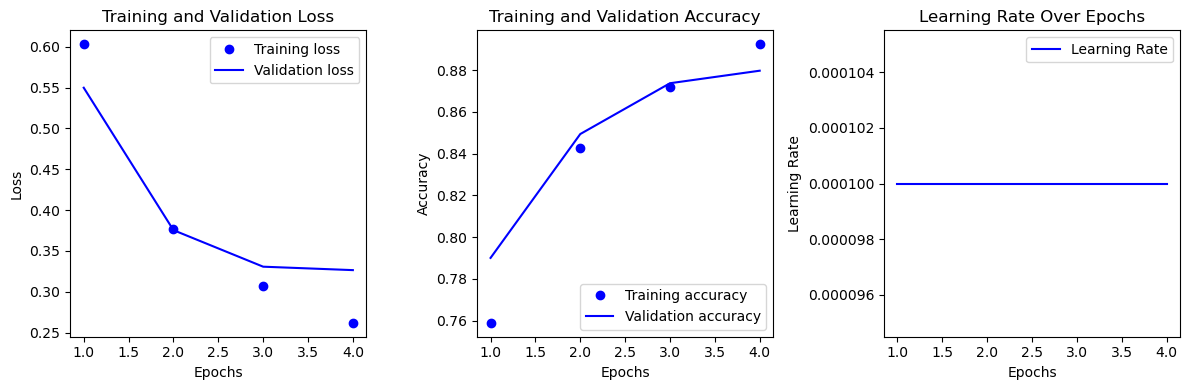

In [13]:
import matplotlib.pyplot as plt

# Extracting data from the history object
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
lr = history_dict['lr']  # If learning rate is recorded

epochs = range(1, len(loss_values) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting learning rate
plt.subplot(1, 3, 3)
plt.plot(epochs, lr, 'b', label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import time
import numpy as np

# Assuming X_test is your test dataset
# Select a batch from X_test. Here, we are using 100 samples for testing.
test_batch = X_test[:100]

# Record the start time
start_time = time.time()

# Make predictions
predictions = model.predict(test_batch)

# Record the end time
end_time = time.time()

# Calculate the total time taken for inference
total_time = end_time - start_time

# Calculate time taken per sample
time_per_sample = total_time / len(test_batch)

print(f"Total time for inference on {len(test_batch)} samples: {total_time} seconds")
print(f"Average time per sample: {time_per_sample} seconds")


4/4 [==============================] - 7s 1s/step
Total time for inference on 100 samples: 6.682700872421265 seconds
Average time per sample: 0.06682700872421264 seconds
